# Correlation with Bootstrap

In [1]:
import numpy as np
import pandas as pd
#from statsmodels.stats import weightstats as stests
from statsmodels.distributions.empirical_distribution import ECDF
#import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

## The data

Let's calculate the correlation coefficient for the same data we used while we compared paired samples.

In [2]:
np.random.seed(12)
grade_before = np.random.normal(85.5, 3, 80)
grade_after  = np.random.normal(86,   4, 80)
#grade_after2 = np.random.normal(90,   3, 80)

## Computing the correlation

Let's use the NumPy function `corrcoef` for calculating the correlation.

In [3]:
np.corrcoef(grade_before, grade_after)

array([[1.        , 0.07143399],
       [0.07143399, 1.        ]])

The result is a symmetric matrix. In this case, we are interested in the non-diagonal values.

In [4]:
np.corrcoef(grade_before, grade_after)[0][1]

0.07143399487184939

In [5]:
# The correlation matrix is symmetric.
np.corrcoef(grade_before, grade_after)[1][0]

0.07143399487184939

In [6]:
corr = np.corrcoef(grade_before, grade_after)[0][1]

In [7]:
x = pd.Series(grade_before)
y = pd.Series(grade_after)

## Calculating the Correlation Sample Distribution

We draw a large number of bootstrapped samples (`num_samples = 10000` for instance), of size `sample_size`, with replacement, from a population consisting of the original data. We draw samples pairwise, meaning that when we sample a value from `grade_before`, we also draw the corresponding value of `grade_after`. With them we calculate the correlation.

`corrSampleDistribution` is the function for generating paired samples WITH replacement and calculate the correlation sample distribution.

In [8]:
def corrSampleDistribution(sample_before, sample_after, num_samples=10000, sample_size=100):
    '''
    It returns a list with the correlation sample distribution.
    '''
    corrSD = np.array([])
    x = pd.Series(sample_before)
    y = pd.Series(sample_after)
    for k in range(num_samples):
        index = np.random.choice(x.index, replace=True, size=sample_size)
        corrSD = np.append(corrSD, np.corrcoef(x[index], y[index])[0][1])
    return(corrSD)  

In [9]:
corrSampDist = corrSampleDistribution(grade_before, grade_after, sample_size=50)

Let's create a function for plot the sample distribution.

In [10]:
def plotSampleDistribution(sampDist):
    '''
    It plots the sample distribution
    '''
    sns.kdeplot(sampDist, shade=True, color='orangered').set(title='Sample Distribution')

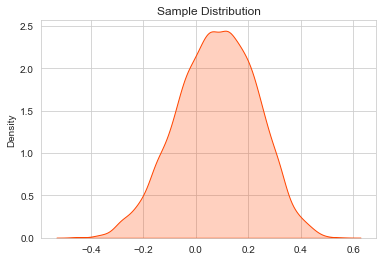

In [11]:
plotSampleDistribution(corrSampDist)

In [12]:
def getpValue(sample_distribution, obs_value, alpha=0.05, alternative='two-sided'):
    '''
    sample_distribution: the sample distribution
    obs_value: observed value 
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [13]:
getpValue(corrSampDist, corr)

0.9436

In [14]:
def hyp_test_corr(sampl_distribution, sampl_value, alpha=0.05, alternative='two-sided'):
    '''
    sampl_value: observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Bootstrap Correlation Hypothesis Test ---')
    print('    Ho: correlation == 0')
    print('    Ha: correlation', sigHa[alternative], '0')
    #print('    Sample Mean = %.2f' %(sampl_value))  
    sampl_distribution_Ho = sampl_distribution - np.mean(sampl_distribution)
    ax = sns.kdeplot(x=sampl_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
    plt.axvline(x=sampl_value, ymin=0, ymax= 0.03, color='black', linewidth=6)
    plt.title('Correlation Sampling Distribution')
    p_val = getpValue(sampl_distribution_Ho, sampl_value, alpha, alternative)
    if alternative=='two-sided':
        cv1 = np.round(np.percentile(sampl_distribution_Ho, (alpha/2)*100),2)    
        cv2 = np.round(np.percentile(sampl_distribution_Ho, 100-alpha*100),2)     
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    elif alternative=='smaller':
        cv1 = np.round(np.percentile(sampl_distribution_Ho, alpha*100),2)  
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    else:
        cv2 = np.round(np.percentile(sampl_distribution_Ho, 100-alpha*100),2)  
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('correlation = %.2f    p-value = %.4f' %(sampl_value, p_val))

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = 0.07    p-value = 0.6734


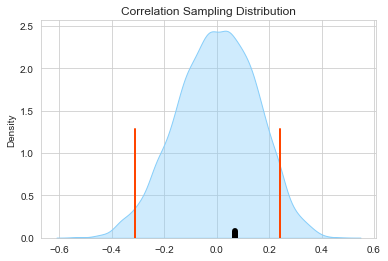

In [15]:
hyp_test_corr(corrSampDist, corr)

## Summarising

To calculate the correlation bootstrap hypothesis test between `x` and `y`, we need to follow the steps:
- Calculate the correlation between `x` and `y`
- Calculate the correlation sample distribution
- Calculate the hypothesis test

In [16]:
def bootCorr(x, y, num_samples=10000, sample_size=100, alpha=0.05, alternative='two-sided'):
    corr = np.corrcoef(x,y)[0][1]
    corrSampDist = corrSampleDistribution(x, y, num_samples=num_samples, sample_size=sample_size)
    hyp_test_corr(corrSampDist, corr, alpha=alpha, alternative=alternative)

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = 0.07    p-value = 0.6670


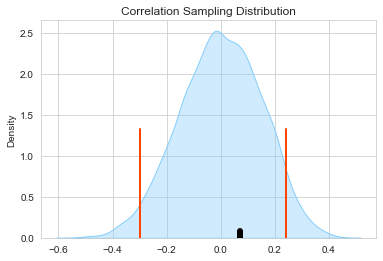

In [17]:
bootCorr(grade_before, grade_after, sample_size=50)

## Examples

In [18]:
df = pd.read_csv('corrExamples.csv')
print(df.shape)
df.head(3)

(50, 6)


,x,y_spc,y_snc,y_wpc,y_wnc,y_nc
0,14.946016,60.934277,-18.311426,15.939970,-5.939970,7.075053
1,12.280831,52.439626,-15.479875,21.534672,-11.534672,9.034883
2,12.554739,52.487695,-15.495898,20.719120,-10.719120,3.187492


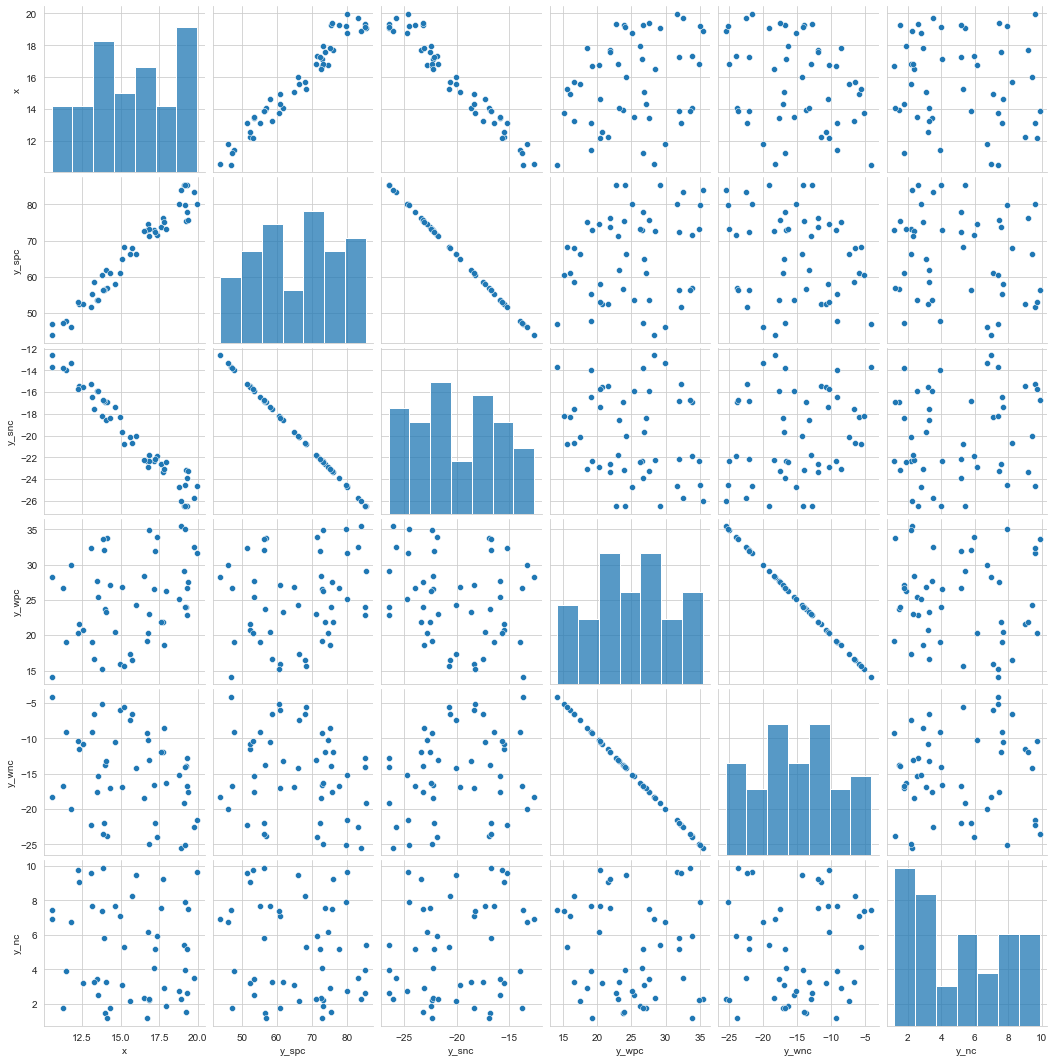

In [19]:
sns.pairplot(df);

### Strong Correlation

In [20]:
size = 30

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = 0.97    p-value = 0.0000


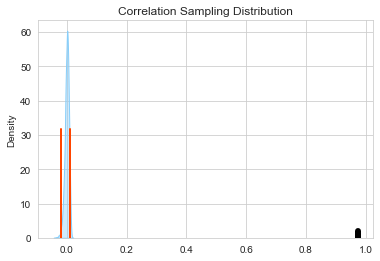

In [21]:
corrSD_spc = bootCorr(df.x, df.y_spc, sample_size=size)

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = -0.97    p-value = 0.0000


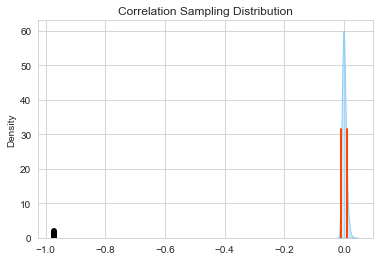

In [22]:
bootCorr(df.x, df.y_snc, sample_size=size)

### Weak Correlation

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = 0.29    p-value = 0.0564


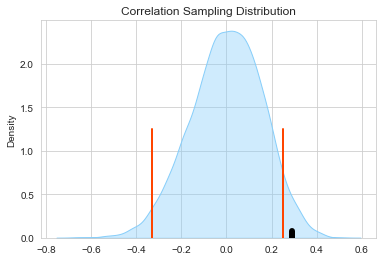

In [23]:
bootCorr(df.x, df.y_wpc, sample_size=size)

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = -0.29    p-value = 0.0554


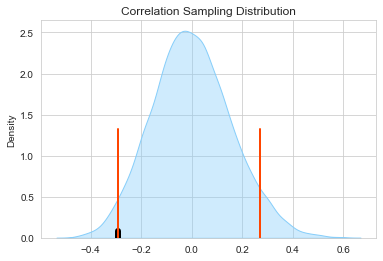

In [24]:
bootCorr(df.x, df.y_wnc, sample_size=size)

### No Correlation

--- Bootstrap Correlation Hypothesis Test ---
    Ho: correlation == 0
    Ha: correlation != 0
correlation = -0.14    p-value = 0.4526


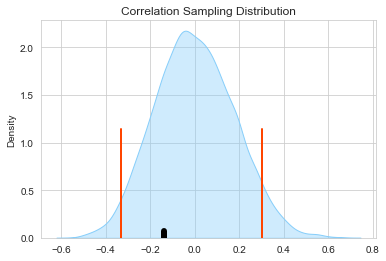

In [25]:
bootCorr(df.x, df.y_nc, sample_size=size)